# Using bpnet-lite and SeqData to train a CTCF profile model
This notebook uses SeqData () to load in a CTCF ChIP-seq dataset and bpnet-lite (https://github.com/jmschrei/bpnet-lite/tree/master) to train a base-pair resolution model in the BPNet style. 

In [1]:
# Imports
import torch
import numpy as np
import xarray as xr
import seqdata as sd
import seqpro as sp
from pathlib import Path
from bpnetlite import BPNet
from eugene import preprocess as pp

# Define paths
data_dir = Path("/cellar/shared/carterlab/data/ml4gland/ENCSR000EGM/data")
fasta = Path("/cellar/users/aklie/data/ml4gland/use_cases/avsec21/reference/hg38.fa")
peaks = data_dir / "peaks.bed"
signals = [data_dir / "plus.bw", data_dir / "minus.bw"]
controls = [data_dir / "control_plus.bw", data_dir / "control_minus.bw"]
control_samples = ['plus', 'minus']
bigwigs = signals + controls
sample_names = ['signal+', 'signal-', 'control+', 'control-']
out = '/cellar/users/dlaub/projects/ML4GLand/use_cases/avsec21/avsec21.zarr'

# Define training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in range(1, 17)]
valid_chroms = ['chr{}'.format(i) for i in range(18, 23)]

# Load data

In [44]:
# Load in the SeqData
sdata = sd.open_zarr(out)

In [45]:
# Split cov into control and signal
sdata['control'] = (
    sdata.cov.sel(cov_sample=['control+', 'control-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata['signal'] = (
    sdata.cov.sel(cov_sample=['signal+', 'signal-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata = sdata.drop_vars(['cov', 'cov_sample'])
sdata

<xarray.Dataset>
Dimensions:     (_sequence: 57244, _length: 2370, cov_strand: 2)
Coordinates:
  * cov_strand  (cov_strand) <U1 '+' '-'
Dimensions without coordinates: _sequence, _length
Data variables: (12/13)
    blockCount  (_sequence) uint64 dask.array<chunksize=(28622,), meta=np.ndarray>
    chrom       (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    chromEnd    (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    chromStart  (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    itemRgb     (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    name        (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    ...          ...
    seq         (_sequence, _length) |S1 dask.array<chunksize=(2048, 2370), meta=np.ndarray>
    strand      (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    thickEnd    (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    thickStart  (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    control     (_sequence, cov_strand, _length) uint16 dask.array<chunksize=(2048, 1, 2370), meta=np.ndarray>
    signal      (_sequence, cov_strand, _length) uint16 dask.array<chunksize=(2048, 1, 2370), meta=np.ndarray>
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [46]:
# Need to upper case the seqs for ohe
sdata["cleaned_seq"] = xr.DataArray(np.char.upper(sdata["seq"]), dims=["_sequence", "_length"])

In [47]:
# Check how many b'N' characters exist in "cleaned_seq"
(sdata["cleaned_seq"] == b"N").sum().values

array(4246)

In [48]:
# Load the training data into memory for faster training
sdata[['cleaned_seq', 'control', 'signal']].load()

<xarray.Dataset>
Dimensions:      (_sequence: 57244, _length: 2370, cov_strand: 2)
Coordinates:
  * cov_strand   (cov_strand) <U1 '+' '-'
Dimensions without coordinates: _sequence, _length
Data variables:
    cleaned_seq  (_sequence, _length) |S1 b'A' b'T' b'C' b'A' ... b'C' b'C' b'C'
    control      (_sequence, cov_strand, _length) uint16 0 0 0 0 0 ... 0 0 0 0 0
    signal       (_sequence, cov_strand, _length) uint16 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [49]:
# Keep only training and validation chromosomes
sdata = sdata.sel(_sequence=((sdata["chrom"].isin(training_chroms)) | (sdata["chrom"].isin(valid_chroms))).compute())

In [50]:
# Train-test split based on chromosomes
pp.train_test_chrom_split(sdata, test_chroms=valid_chroms)
sdata_train = sdata.sel(_sequence=(sdata["train_val"]==True).compute())
sdata_valid = sdata.sel(_sequence=(sdata["train_val"]==False).compute())

In [51]:
# Check that the chromosomes are correct
sdata_train["chrom"].to_series().value_counts(), sdata_valid["chrom"].to_series().value_counts()

(chr1     6085
 chr2     4260
 chr6     3557
 chr3     3437
 chr7     3220
 chr11    3055
 chr5     2990
 chr12    2801
 chr10    2668
 chr8     2480
 chr4     2378
 chr9     2173
 chr16    2120
 chr15    1915
 chr14    1601
 chr13    1063
 Name: chrom, dtype: int64,
 chr19    2387
 chr20    1589
 chr22    1301
 chr18    1086
 chr21     688
 Name: chrom, dtype: int64)

In [59]:
# Define training transformations
from eugene.dataload._augment import RandomRC

def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return x

def cov_dtype(x):
    return tuple(arr.astype('f4') for arr in x)

def jitter(x):
    return sp.jitter(*x, max_jitter=128, length_axis=-1, jitter_axes=0)

def to_tensor(x):
    return tuple(torch.tensor(arr, dtype=torch.float32) for arr in x)

def random_rc(x):
    return RandomRC(rc_prob=0.5)(*x)

# Get the train dataloader
dl = sd.get_torch_dataloader(
    sdata_train,
    sample_dims=['_sequence'],
    variables=['cleaned_seq', 'control', 'signal'],
    prefetch_factor=None,
    batch_size=32,
    transforms={
        ('cleaned_seq', 'control', 'signal'): jitter,
        'cleaned_seq': seq_trans,
        'signal': lambda x: x[..., 557:-557],
        ('control', 'signal'): cov_dtype,
        ('control', 'cleaned_seq', 'signal'): to_tensor,
        ('signal', 'control', 'cleaned_seq'): random_rc
    },
    return_tuples=True,
    shuffle=True,
)

In [60]:
# Test a batch
batch = next(iter(dl))
[x.shape for x in batch]

[torch.Size([32, 4, 2114]),
 torch.Size([32, 2, 2114]),
 torch.Size([32, 2, 1000])]

In [61]:
# Get the validation data
def seq_trans(x):
    x = x[..., 128:-128]
    np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return torch.as_tensor(x.astype('f4'))

def ctl_trans(x):
    x = x[..., 128:-128]
    return torch.as_tensor(x.astype('f4'))

def cov_trans(x):
    x = x[..., 128+557:-128-557]
    return torch.as_tensor(x.astype('f4'))

X_valid = seq_trans(sdata_valid["cleaned_seq"].values)
X_ctl_valid = ctl_trans(sdata_valid["control"].values)
y_valid = cov_trans(sdata_valid["signal"].values)
X_valid.shape, X_ctl_valid.shape, y_valid.shape

(torch.Size([7051, 4, 2114]),
 torch.Size([7051, 2, 2114]),
 torch.Size([7051, 2, 1000]))

# Train a model

In [62]:
# Create the model, we need 2 channels for the control tracks, 2 channels for the signal tracks, and to trim to 1000 bp of input
model = BPNet(n_outputs=2, n_control_tracks=2, trimming=(2114 - 1000) // 2, name="bpnet.seqdata")

In [63]:
# Test out a prediction batch
batch = next(iter(dl))
pred_ctl = model.forward(*batch[:2])
pred_ctl[0].shape, pred_ctl[1].shape

(torch.Size([32, 2, 1000]), torch.Size([32, 1]))

In [64]:
# Send the model to the GPU
model.cuda()

BPNet(
  (iconv): Conv1d(4, 64, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (rrelus): ModuleList(
    (0-7): 8 x ReLU()
  )
  (fconv): Conv1d(66, 2, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=65, out_features=1, bias=True)
)

In [65]:
# Quickly define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [66]:
# Use the models fit_generator method to train the model
res = model.fit(
    dl,
    optimizer,
    X_valid=X_valid,
	X_ctl_valid=X_ctl_valid,
    y_valid=y_valid,
    max_epochs=50
)

Epoch	Iteration	Training Time	Validation Time	Training MNLL	Training Count MSE	Validation MNLL	Validation Profile Pearson	Validation Count Pearson	Validation Count MSE	Saved?
0	0	0.9792	1.2428	579.8674	12.9123	778.8552	-0.002782609	-0.3159749	8.2522	True
0	100	5.7987	1.4503	531.6778	2.0953	342.217	0.07649835	0.17062369	0.7509	True
0	200	7.1846	1.2526	443.7212	0.6143	322.0447	0.19680695	0.124152645	0.9065	True
0	300	6.3491	1.2522	489.2322	0.6146	290.2345	0.33195034	0.26211742	0.7384	True
0	400	5.7646	1.2521	443.2282	0.476	282.0833	0.35965452	0.3812014	0.6644	True
0	500	5.7285	1.2555	451.7318	0.7043	276.313	0.37986064	0.4218249	0.6401	True
0	600	5.8486	1.2545	402.3587	0.5056	275.2049	0.3859403	0.5090792	0.801	True
0	700	6.8118	1.2566	430.6187	0.4381	273.5514	0.39022195	0.537668	0.795	True
0	800	5.6593	1.2713	479.1301	0.666	272.7185	0.39624706	0.5560775	0.7955	True
0	900	6.2042	1.2563	396.331	0.4898	271.8433	0.3995669	0.53729975	1.1332	True
0	1000	6.3393	1.2574	395.2224	0.3712	271.4224	0.

# Generate a training curve and pull the stats for the best model

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [5]:
bpnetlite_log = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/seqdata/bpnet.seqdata.log", sep="\t")

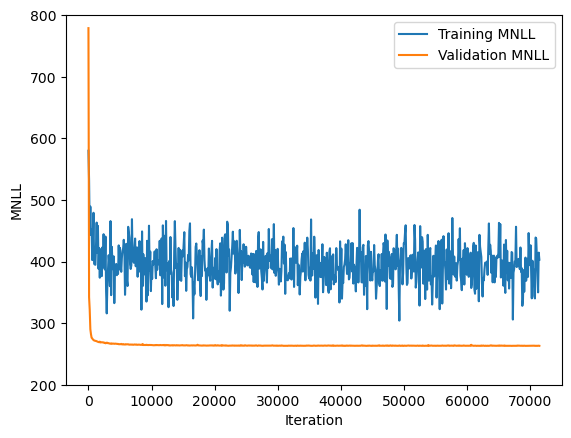

In [9]:
# Plot "MNLL" over "Iteration"
plt.plot(bpnetlite_log["Iteration"], bpnetlite_log["Training MNLL"], label="Training MNLL")
plt.plot(bpnetlite_log["Iteration"], bpnetlite_log["Validation MNLL"], label="Validation MNLL")
plt.xlabel("Iteration")
plt.ylabel("MNLL")
plt.ylim(200, 800)
plt.legend()
plt.savefig("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/bpnet/seqdata_mnll.pdf", bbox_inches="tight", dpi=300)

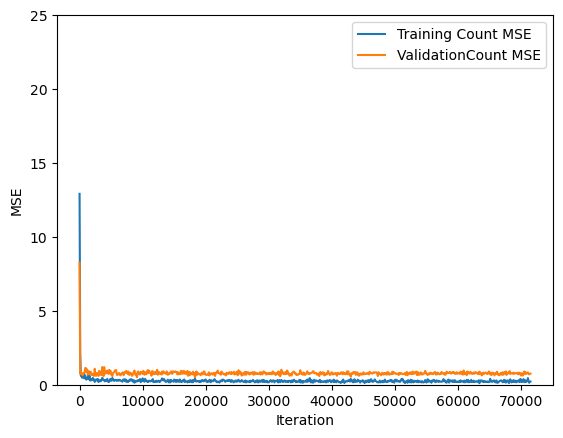

In [11]:
# Plot "MSE" over "Iteration"
plt.plot(bpnetlite_log["Iteration"], bpnetlite_log["Training Count MSE"], label="Training Count MSE")
plt.plot(bpnetlite_log["Iteration"], bpnetlite_log["Validation Count MSE"], label="ValidationCount MSE")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.ylim(0, 25)
plt.legend()
plt.savefig("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/bpnet/seqdata_mse.pdf", bbox_inches="tight", dpi=300)

In [8]:
# Get the last row of where "Saved?" is True
bpnetlite_final_log = bpnetlite_log[bpnetlite_log["Saved?"] == True].iloc[-1]
bpnetlite_final_log["type"] = "bpnetlite"
bpnetlite_final_log.to_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/seqdata/bpnet.seqdata.log.final", sep="\t", index=True, header=False)

# Scratch

In [ ]:
import numpy as np
from typing import Tuple, Union

def random_rc(x: np.ndarray, rc_prob: float = 0.5) -> Union[np.ndarray, Tuple[np.ndarray]]:
    """Randomly applies a reverse-complement transformation to each sequence in a training
    batch according to a user-defined probability, rc_prob. This is applied to each sequence
    independently.

    Parameters
    ----------
    x : np.ndarray
        Batch (or tuple of batches) of one-hot sequences (shape: (N, A, L)).
    rc_prob : float, optional
        Probability to apply a reverse-complement transformation, defaults to 0.5.

    Returns
    -------
    np.ndarray
        Sequences with random reverse-complements applied.
    """
    n = x.shape[0]
    # randomly select sequences to apply rc transformation
    ind_rc = np.random.rand(n) < rc_prob

    # make a copy of the sequence
    x_aug = np.copy(x)

    # apply reverse-complement transformation
    x_aug[ind_rc] = np.flip(x_aug[ind_rc], axis=(1, 2))

    return x_aug

In [ ]:
# Define training transformations
def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    #print("Post ohe:", (x.shape, x.dtype))
    return x

def cov_dtype(x):
    #[print("Pre cov:", (x.shape, x.dtype)) for x in x]
    return tuple(arr.astype('f4') for arr in x)

def jitter(x):
    #[print("Pre jitter:", (x.shape, x.dtype)) for x in x]
    return sp.jitter(*x, max_jitter=128, length_axis=-1, jitter_axes=0)

def to_tensor(x):
    #[print("Pre tensor:", x.shape, x.dtype) for x in x]
    return tuple(torch.tensor(arr, dtype=torch.float32) for arr in x)

def random_rc(x):
    #[print("Pre rc:",x.shape, x.dtype) for x in x]
    return RandomRC()(*x)

# Get the train dataloader
dl = sd.get_torch_dataloader(
    sdata_train,
    sample_dims=['_sequence'],
    variables=['cleaned_seq', 'control', 'signal'],
    prefetch_factor=None,
    batch_size=32,
    transforms={
        ('cleaned_seq', 'control', 'signal'): jitter,
        'cleaned_seq': seq_trans,
        'signal': lambda x: x[..., 557:-557],
        ('control', 'signal'): cov_dtype,
        ('control', 'cleaned_seq', 'signal'): to_tensor,
        ('signal', 'control', 'cleaned_seq'): random_rc
    },
    return_tuples=True
)

In [ ]:
# 
_transforms = {
    ('seq', 'control', 'signal'): jitter,
    'seq': seq_trans,
    'signal': lambda x: x[..., 557:-557],
    ('control', 'signal'): cov_dtype
}

In [ ]:
vars_with_transforms = set()
for k in _transforms:
    if isinstance(k, tuple):
        vars_with_transforms.update(k)
    else:
        vars_with_transforms.add(k)

In [ ]:
def seq_trans(x):
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    jitter = RandomJitter(128, -1)
    x = jitter(x)
    return torch.as_tensor(x.astype('f4'))

def ctl_trans(x):
    x = x[..., 128:-128]
    return torch.as_tensor(x.astype('f4'))

def cov_trans(x):
    x = x[..., 128+557:-128-557]
    return torch.as_tensor(x.astype('f4'))

dl = sd.get_torch_dataloader(
    sdata,
    sample_dims=['_sequence'],
    variables=['seq', 'control', 'signal'],
    prefetch_factor=None,
    batch_size=8,
    transforms={
        'seq': seq_trans,
        'control': ctl_trans,
        'signal': cov_trans,
    },
    return_tuples=True
)

In [ ]:
# Test out
example_seq = sdata_train["cleaned_seq"][0:64].values
example_ctl = sdata_train["control"][0:64].values
example_signal = sdata_train["signal"][0:64].values

In [ ]:
# Jitter first
jitter_out = jitter((example_seq, example_ctl, example_signal))
jittered_seq = jitter_out[0]
jittered_ctl = jitter_out[1]
jittered_signal = jitter_out[2]
jittered_seq.shape, jittered_ctl.shape, jittered_signal.shape

((64, 2114), (64, 2, 2114), (64, 2, 2114))

In [ ]:
# Then complete transforms
seq = seq_trans(jittered_seq)
ctl, signal = cov_dtype((jittered_ctl, jittered_signal[..., 557:-557]))

In [ ]:
# How does this look?
seq.shape, signal.shape, ctl.shape

((64, 4, 2114), (64, 2, 1000), (64, 2, 2114))